### Topic Modeling

Large amounts of data are collected everyday. As more information becomes available, it becomes difficult to access what we are looking for. So, we need tools and techniques to organize, search and understand vast quantities of information.

Topic modelling provides us with methods to organize, understand and summarize large collections of textual information. It helps in:
- Discovering hidden topical patterns that are present across the collection
- Annotating documents according to these topics
- Using these annotations to organize, search and summarize texts

Topic Modelling is different from rule-based text mining approaches that use regular expressions or dictionary based keyword searching techniques. It is an unsupervised approach used for finding and observing the bunch of words (called “topics”) in large clusters of texts.

Topics can be defined as “a repeating pattern of co-occurring terms in a corpus”. A good topic model should result in – “health”, “doctor”, “patient”, “hospital” for a topic – Healthcare, and “farm”, “crops”, “wheat” for a topic – “Farming”.

### Imports

In [1]:
# Load the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_colwidth", 200)

### Load data

I used **20 Newsgroup** data. You can [Download](https://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups). Or the below script will download itself.

In [2]:
# Load data
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [3]:
# Look at the dataset
documents[:2]

["Well i'm not sure about the story nad it did seem biased. What\nI disagree with is your statement that the U.S. Media is out to\nruin Israels reputation. That is rediculous. The U.S. media is\nthe most pro-israeli media in the world. Having lived in Europe\nI realize that incidences such as the one described in the\nletter have occured. The U.S. media as a whole seem to try to\nignore them. The U.S. is subsidizing Israels existance and the\nEuropeans are not (at least not to the same degree). So I think\nthat might be a reason they report more clearly on the\natrocities.\n\tWhat is a shame is that in Austria, daily reports of\nthe inhuman acts commited by Israeli soldiers and the blessing\nreceived from the Government makes some of the Holocaust guilt\ngo away. After all, look how the Jews are treating other races\nwhen they got power. It is unfortunate.\n",
 "\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap

In [4]:
print("Total Documents: ", len(documents))

Total Documents:  11314


In [5]:
dataset.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

This dataset has **11,314** text documents distributed across **20** different newsgroups.

### Preprocessing

In [6]:
# Load data from list to datafame for further processing.
news_df = pd.DataFrame({'document':documents})

# Removing everything except alphabets (i.e. the punctuations, numbers, and special characters) 
# and will replace them with blank space
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z#]", " ")

# removing short words because they usually don’t contain useful information
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase to nullify case sensitivity.
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

It’s also important to remove the stop-words from the text data as they are mostly clutter and hardly carry any information. Stop-words are terms like ‘it’, ‘they’, ‘am’, ‘been’, ‘about’, ‘because’, ‘while’, 'the', etc.

To remove stop-words from the documents, we will have to tokenize the text, i.e., split the string of text into individual tokens or words. We will stitch the tokens back together once we have removed the stop-words.

In [7]:
# Load stopwords (here I used Spacy for stopwords you can also use NLTK)
from spacy.lang.en.stop_words import STOP_WORDS as stop_words

# tokenization - break sentences into words
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())

# remove stop-words
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

# de-tokenization - Join words to get back the sentences
detokenized_doc = []
for i in range(len(news_df)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

news_df['clean_doc'] = detokenized_doc

### Document-Term Matrix

Let’s say we have **m** number of text documents with **n** number of total unique terms (words). We wish to extract **k** topics from all the text data in the documents. The number of topics, **k**, has to be specified by the user.

- Generate a document-term matrix of shape **m x n** having TF-IDF scores.
![Document - Term Image](./dt.png)

- Then, we will reduce the dimensions of the above matrix to ***k*** (no. of desired topics) dimensions, using singular-value decomposition (**SVD**).
- **SVD** decomposes a matrix into three other matrices. Suppose we want to decompose a matrix ***A*** using SVD. It will be decomposed into matrix ***U***, matrix ***S***, and **VT** (transpose of matrix ***V***).

![Formula Image](./formula.png)
![Matrix Image](./svd.png)


This is the first step towards topic modeling. We will use sklearn’s TfidfVectorizer to create a document-term matrix with **1,000** terms.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', 
max_features= 1000, # keep top 1000 terms 
max_df = 0.5, 
smooth_idf=True)

X = vectorizer.fit_transform(news_df['clean_doc'])

X.shape # check shape of the document-term matrix

(11314, 1000)

So ***X*** is same matrix as **U** shown above.

NOTE : Due to computation limits I have restricted the number of features to 1,000.

 - Each row of the matrix ***Uk*** (document-term matrix) is the vector representation of the corresponding document. The length of these vectors is ***k***, which is the number of desired topics. Vector representation for the terms in our data can be found in the matrix ***Vk*** (term-topic matrix).
 - So, SVD gives us vectors for every document and term in our data. The length of each vector would be ***k***. We can then use these vectors to find similar words and similar documents using the cosine similarity method.

### Topic Modeling

The next step is to represent each and every term and document as a vector. We will use the document-term matrix and decompose it into multiple matrices. We will use sklearn’s TruncatedSVD to perform the task of matrix decomposition.

Since the data comes from 20 different newsgroups, let’s try to have 20 topics for our text data. The number of topics can be specified by using the n_components parameter.

In [9]:
from sklearn.decomposition import TruncatedSVD

# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=20, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

len(svd_model.components_)

20

The components of svd_model are our topics, and we can access them using ***svd_model.components_***. Finally, let’s print a few most important words in each of the ***20*** topics and see how our model has done.


In [10]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    print("Topic "+str(i)+": ", end='', flush=True)
    for t in sorted_terms:
        print(t[0], end=' ', flush=True)
    print(" ")

Topic 0: like know people think good time thanks  
Topic 1: thanks windows card drive mail file advance  
Topic 2: game team year games season players good  
Topic 3: drive scsi hard disk card drives problem  
Topic 4: windows file window files program problem version  
Topic 5: government space chip mail information data encryption  
Topic 6: like bike chip sounds know looks look  
Topic 7: card sale video monitor offer price jesus  
Topic 8: know card chip video government people clipper  
Topic 9: good know time bike problem jesus work  
Topic 10: think good chip clipper need encryption people  
Topic 11: thanks problem right bike good window time  
Topic 12: good people windows know sale file files  
Topic 13: space think know nasa problem year israel  
Topic 14: space good card thanks people year nasa  
Topic 15: people problem game window time work want  
Topic 16: problem good window israel people know israeli  
Topic 17: file time problem need files mail game  
Topic 18: need r

Topics Visualization

To find out how distinct our topics are, we should visualize them. Of course, we cannot visualize more than 3 dimensions, but there are techniques like ***PCA*** and ***t-SNE*** which can help us visualize high dimensional data into lower dimensions. Here we will use ***t-SNE***.

In [12]:
from sklearn.manifold import TSNE
embedding = TSNE(n_components=2).fit_transform(X_topics)

(11314, 2)

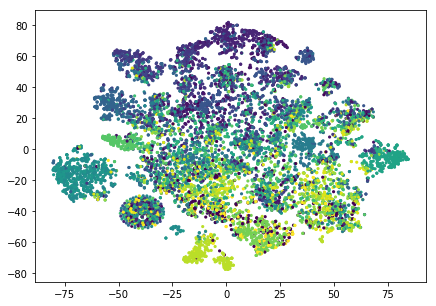

In [13]:
plt.figure(figsize=(7,5))
plt.scatter(embedding[:, 0], embedding[:, 1], 
c = dataset.target,
s = 10, # size
edgecolor='none'
)
plt.show()

As you can see above, the result is quite beautiful. Each dot represents a document and the colours represent the 20 newsgroups. Our LSA model seems to have done a good job. Feel free to play around with the parameters of **t-SNE** to see how the plot changes its shape.